In [12]:
import geopandas as gpd
import geoplot as gplt
import pandas as pd
import numpy as np

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
from matplotlib_scalebar.scalebar import ScaleBar

import mapclassify as mc
import math

from handlers import TextLegendHandler
from helper_scripts import utils

# set up a handler for text legends
Legend.update_default_handler_map({str: TextLegendHandler.TextHandler()})

# update default font
plt.rcParams["font.family"] = "Frutiger Light Condensed"

In [129]:
def preprocess_data(data: pd.DataFrame, post: str, party: str) -> pd.DataFrame:
    """
    Preprocesses the data and aggregates it by party and palikas
    for the specific post and the specific party

    Args:
        post (str): the post in contention
        party (str): the political party in contention
    """
    preprocessed_data = data[(data["contested_post"] == post)]
    preprocessed_data = preprocessed_data[["party", "palika", "votes"]]
    preprocessed_data["palika"] = preprocessed_data["palika"].transform(
        lambda x: utils.transform_to_capitalized_case(x, "-")
    )
    preprocessed_data = (
        preprocessed_data.groupby(["party", "palika"]).sum().reset_index()
    )

    preprocessed_data["% of palika votes"] = (
        preprocessed_data["votes"]
        / preprocessed_data.groupby("palika")["votes"].transform("sum")
        * 100
    )

    preprocessed_data = preprocessed_data[preprocessed_data["party"] == party]

    return preprocessed_data


def annotate_palikas(
    axis,
    geodata_salyan,
    #  annotation_kwargs=ANNOTATION_KWARGS
):
    """
    Args:
        axis (matplotlib.axes): the figure axis
        wards_data_ktm (geopandas dataframe object): ktm ward geodataframe
        annotation_kwargs (dict, optional): kwargs for axis.annotate(). Defaults to ANNOTATION_KWARGS.
    """
    min_area_ward = geodata_salyan.to_crs(crs=3857).geometry.area.min()
    for geometry, label in zip(geodata_salyan.geometry, geodata_salyan.NAME):
        if label == "Kumakh Malika":
            xycoords = (
                geometry.centroid.coords[0][0] - 0.05,
                geometry.centroid.coords[0][1],
            )
        elif label == "Dhorchaur":
            xycoords = (
                geometry.centroid.coords[0][0] - 0.04,
                geometry.centroid.coords[0][1],
            )
        elif label == "Bangad Kupinde":
            xycoords = (
                geometry.centroid.coords[0][0] - 0.05,
                geometry.centroid.coords[0][1] - 0.06,
            )
        else:
            xycoords = (
                geometry.centroid.coords[0][0] - 0.04,
                geometry.centroid.coords[0][1] - 0.01,
            )

        axis.annotate(
            text=label,
            xy=xycoords,
            label=label,
            fontweight="heavy",
            # fc='white',
            fontsize=10 + 0.7 * (geometry.area / min_area_ward),
            color="white"
            # **annotation_kwargs
        )

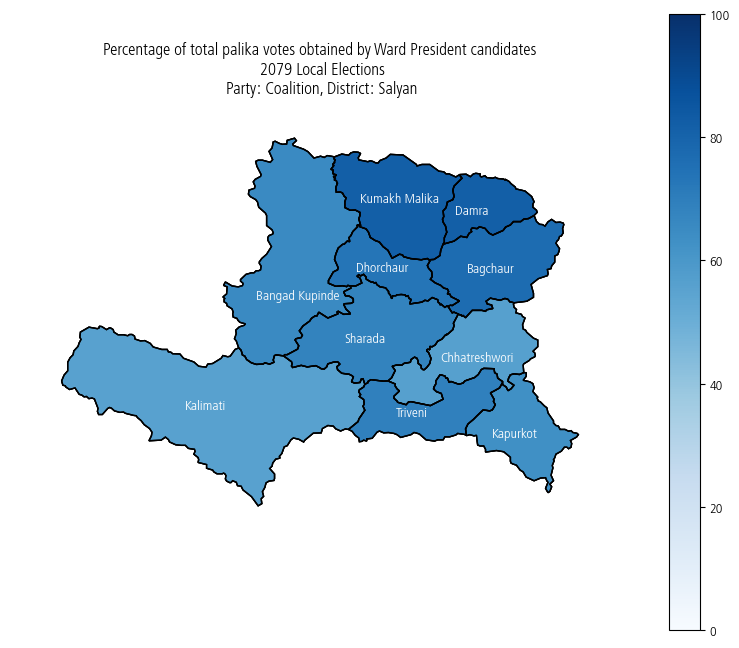

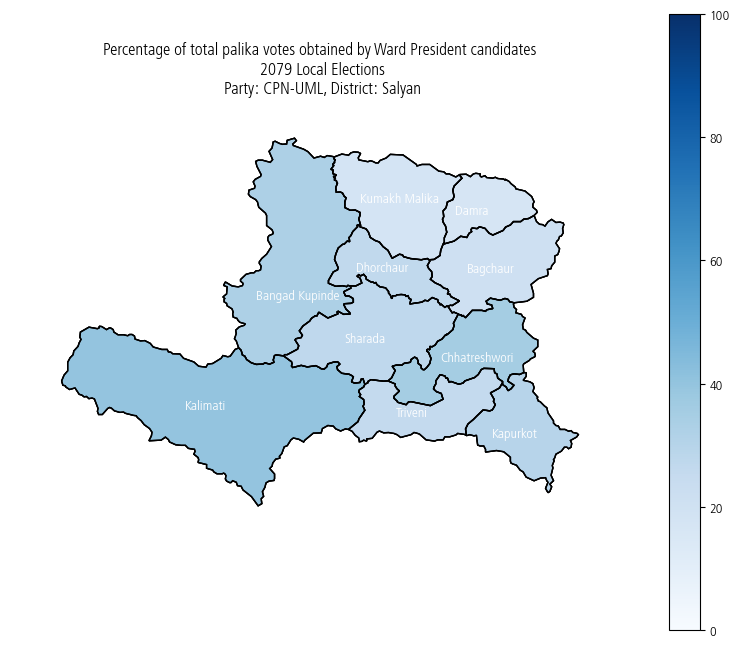

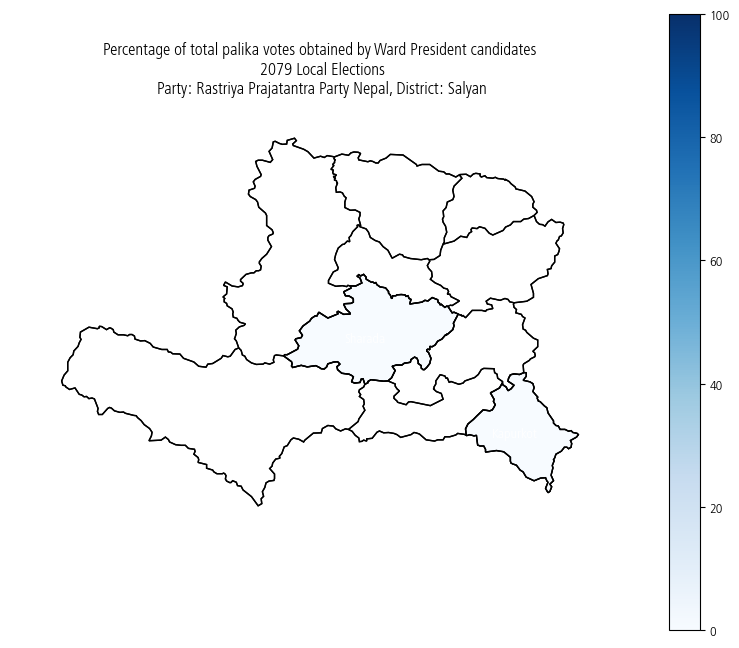

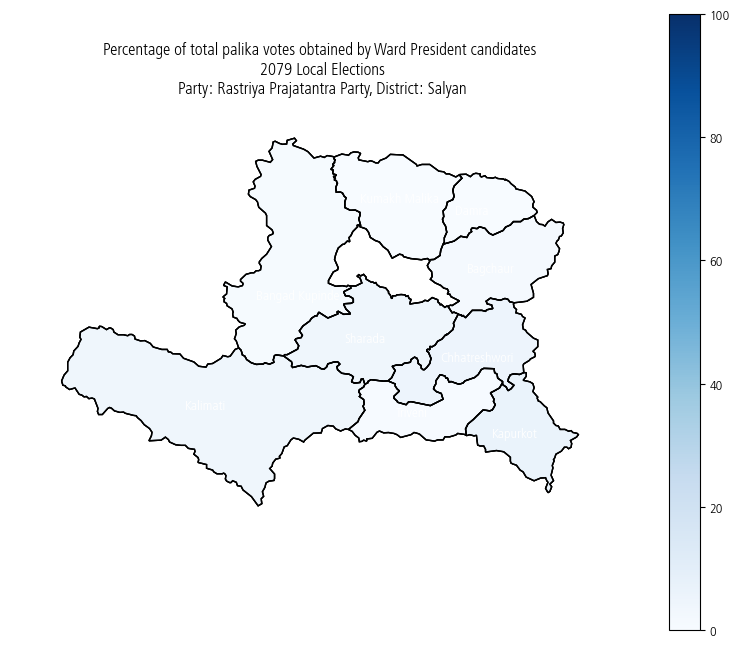

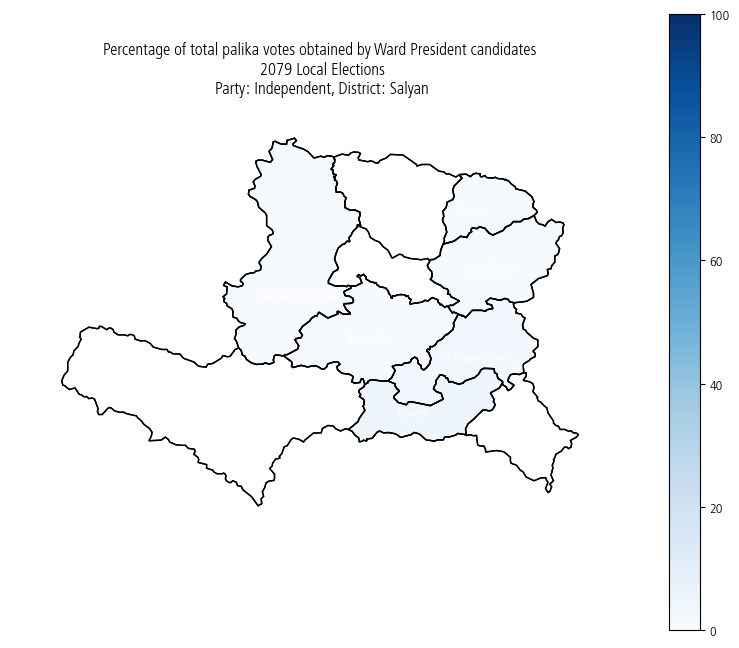

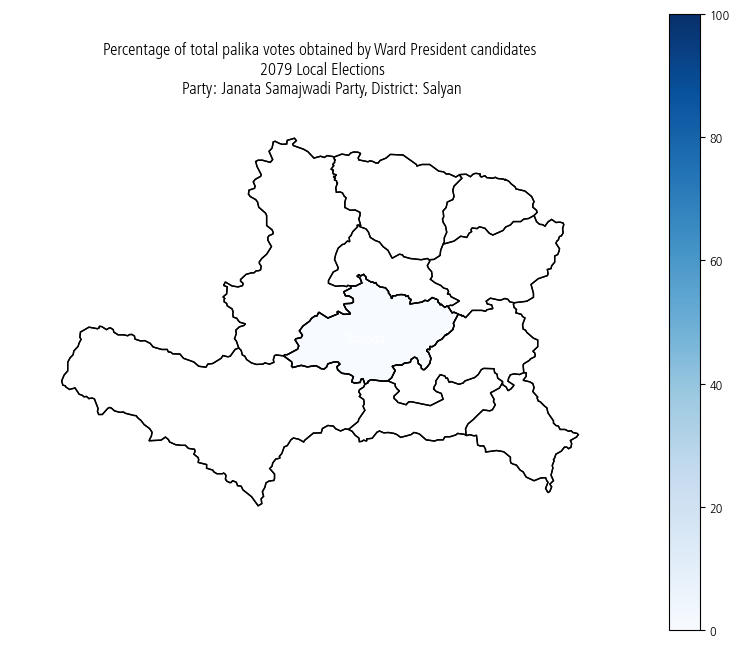

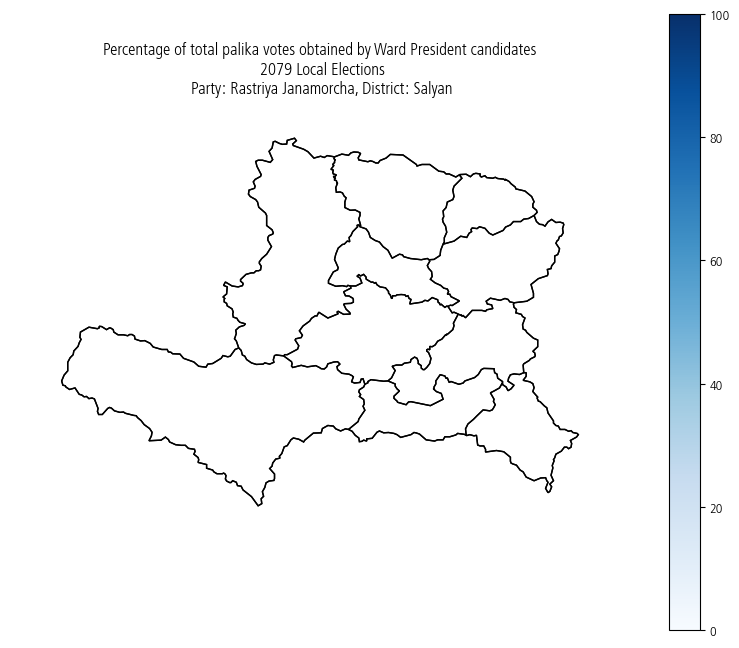

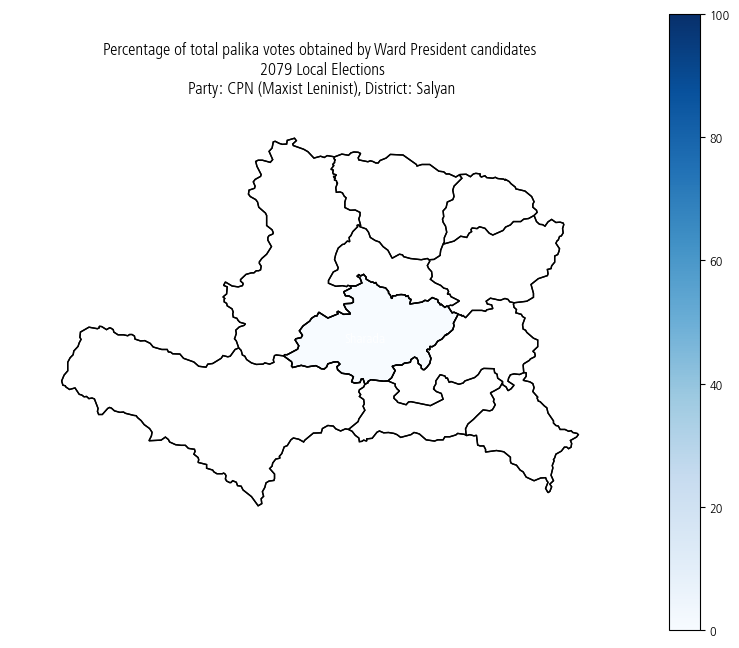

In [130]:
elec_data = pd.read_csv("../../data/election_data/ward_votes_all.csv")
elec_data.loc[
    (elec_data["party"] == "Nepali Congress")
    | (elec_data["party"] == "Maoist Centre")
    | (elec_data["party"] == "CPN (Unified Socialist)"),
    "party",
] = "Coalition"

map_data = gpd.read_file("../../data/nepal_map_data/nepal_local.geojson")
elec_data_gorkha = elec_data.query('district.str.contains("salyan")', engine="python")
local_data_gorkha = map_data.query('DISTRICT.str.contains("Salyan")', engine="python")

parties = elec_data_gorkha["party"].unique()

for party in parties:
    norm = matplotlib.colors.Normalize(vmin=0, vmax=100)
    cmap = matplotlib.cm.ScalarMappable(norm=norm, cmap="Blues").cmap
    preprocessed_data = gpd.GeoDataFrame(
        preprocess_data(elec_data_gorkha, "Member", party).merge(
            local_data_gorkha, how="inner", left_on=["palika"], right_on=["NAME"]
        )
    )

    axis = gplt.choropleth(
        preprocessed_data,
        hue="% of palika votes",
        cmap=cmap,
        norm=norm,
        legend=True,
        figsize=(10, 8)
        # zorder=100,
    )
    gplt.polyplot(local_data_gorkha, linestyle="-", ax=axis, zorder=500)
    gplt.polyplot(
        local_data_gorkha.copy().dissolve(by="DISTRICT"),
        ax=axis,
        linestyle="-",
        # edgecolor="gray",
        # zorder=10000,
    )

    annotate_palikas(axis, preprocessed_data)

    plt.title(
        f"Percentage of total palika votes obtained by Ward President candidates\n 2079 Local Elections\n Party: {party}, District: Salyan"
    )